## Установка библиотек

In [1]:
%pip install tensorflow >> None
%pip install plotly >> None
%pip install salesforce-merlion >> None
%pip install torch >> None
%pip install "gluonts[torch]" >> None
%pip install darts >> None
%pip install pypots >> None
%pip install fastdtw >> None
%pip install darts >> None
%pip install ta >> None

## Импорт_библиотек

In [2]:
# main----------------------------------------------
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
from datetime import datetime
import csv
from google.colab import drive
import time

# graph---------------------------------------------
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# plotly--------------------------------------------
import plotly.express as px
import plotly.graph_objects as go

# torch---------------------------------------------
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch import nn

# sklearn-------------------------------------------
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

# tensorflow----------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import TimeDistributed, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, mse

# tqdm-----------------------------------------------
from tqdm.keras import TqdmCallback
from tqdm import tqdm

# frameworks-----------------------------------------
import prophet
# from merlion.utils import TimeSeries
#from fbprophet import Prophet
#from fbprophet.diagnostics import cross_validation
#from fbprophet.diagnostics import performance_metrics
#from fbprophet.plot import plot_cross_validation_metric
#from orion import Orion
#from orion.analysis import analyze
#from orion.data import load_signal
#from orion.primitives.tadgan import TadGAN

# Darts---------------------------------------------
# https://github.com/unit8co/darts
# from darts import TimeSeries
#from darts.datasets import ETTh2Dataset
#from darts.ad import KMeansScorer
#from darts.ad import QuantileDetector
#from darts.dataprocessing.transformers import Scaler

# PyPots--------------------------------------------
from pypots.data import load_specific_dataset

# Trading-------------------------------------------
import ta
from ta.trend import ADXIndicator

# Prerequisites-------------------------------------
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 16, 6
np.random.seed(1)
tf.random.set_seed(1)
print('Tensorflow version:', tf.__version__)
print(prophet.__version__)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

drive.mount('/content/drive')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Tensorflow version: 2.15.0
1.1.5
Mounted at /content/drive


## Импортирование_конвертация_данных

In [3]:
def tsv_to_csv(tsv_file, csv_file):
    with open(tsv_file, 'r', newline='', encoding='utf-8') as tsvfile:
        tsvreader = csv.reader(tsvfile, delimiter='\t')
        with open(csv_file, 'w', newline='', encoding='utf-8') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerows(tsvreader)

#tsv_to_csv('/content/metrics_collector.tsv', '/content/metrics_collector.csv')
#print('Successfully converted')

In [4]:
# загрузка данных
df = pd.read_table('/content/drive/MyDrive/Hackatons/RedLab_Anomaly_Detection/metrics_collector.tsv', delimiter= '\t')
#df = pd.read_table('/content/drive/MyDrive/Hackatons/RedLab_Hack/metrics_collector.tsv', delimiter= '\t')
df.shape

(18363749, 19)

In [5]:
# переименование колонок
df.rename(columns={'1': 'account_id',
                   'AgentCheck/CircuitBreaker/tripped/all' : 'name',
                   '2024-04-15 23:32:00' : 'point',
                   '0' : 'call_count',
                   '0.1' : 'total_call_time',
                   '0.2' : 'total_exclusive_time',
                   '0.3' : 'min_call_time',
                   '0.4' : 'max_call_time',
                   '0.5' : 'sum_of_squares',
                   '1.1' : 'instances',
                   'java': 'language',
                   '[GMonit] Collector' : 'app_name',
                   '17592186045423' : 'app_id',
                   'Unnamed: 13' : 'scope',
                   '575f5ba20b4b' : 'host',
                   '575f5ba20b4b.1' : 'display_host',
                   '1.2' : 'pid',
                   '8.5.0' : 'agent_version',
                   '{}' : 'labels'
                   }, inplace=True)

# конвертация в тип даты
df['point'] = pd.to_datetime(df['point'])

## Разведка_по_данным

In [6]:
# Удаляем колонки, так как все по 1 и дубликатов у нас нет
df = df.drop(columns=['account_id', 'language',
                      'app_name', 'app_id',
                      'host', 'display_host',
                      'pid', 'agent_version',
                      'labels', 'name', 'scope'])

In [7]:
# удаляем строки с nan
df = df.dropna(subset=['call_count',
                       'total_call_time', 'total_exclusive_time',
                       'min_call_time', 'max_call_time',
                       'sum_of_squares', 'instances'])

In [ ]:
# проверка на nan
def check_nan(dataset):
    list_nan = dataset.isna().sum()
    for i in range(len(list_nan)):
        if(list_nan[i] != 0):
          print(list_nan[i])

# проверка на null
def check_null(dataset):
    list_null = dataset.isnull().sum()
    for i in range(len(list_null)):
        if(list_null[i] != 0):
          print(list_null[i])

In [ ]:
check_nan(df)

In [ ]:
check_null(df)

In [11]:
# скосс и эксцесс
def diagnostics_skewness(df):
    col_list = df.select_dtypes(include=['number']).columns
    skew_initial_list = []
    skew_pos_reciprocal_list = []
    skew_neg_reciprocal_list = []
    skew_log_list = []
    skew_corr_log_001_list = []
    skew_corr_log_01_list = []
    skew_corr_log_1_list = []
    skew_corr_log_5_list = []
    skew_cbrt_list = []
    skew_sqrt_list = []

    df_ = df.copy()
    for i in col_list:
        df_[i] = df_[i].fillna(df_[i].median())
        skew_initial = df_[i].skew()
        skew_pos_reciprocal = (1 / (df_[i].clip(0.01))).skew()
        skew_neg_reciprocal = (-1 / (df_[i].clip(0.01))).skew()
        skew_log = np.log(df[i].clip(0.01)).skew()
        skew_corr_log_001 = np.log((df_[i].clip(0.01) /
                                    df_[i].mean()) + 0.001).skew()
        skew_corr_log_01 = np.log((df_[i].clip(0.01) /
                                    df_[i].mean()) + 0.01).skew()
        skew_corr_log_1 = np.log((df_[i].clip(0.01) /
                                    df_[i].mean()) + 0.1).skew()
        skew_corr_log_5 = np.log((df_[i].clip(0.01) /
                                    df_[i].mean()) + 0.5).skew()
        skew_cbrt = (np.sign(df_[i]) * np.cbrt(df_[i].abs())).skew()
        skew_sqrt = (np.sign(df_[i]) * np.sqrt(df_[i].abs())).skew()
        skew_initial_list.append(skew_initial)
        skew_pos_reciprocal_list.append(skew_pos_reciprocal)
        skew_neg_reciprocal_list.append(skew_neg_reciprocal)
        skew_log_list.append(skew_log)
        skew_corr_log_001_list.append(skew_corr_log_001)
        skew_corr_log_01_list.append(skew_corr_log_01)
        skew_corr_log_1_list.append(skew_corr_log_1)
        skew_corr_log_5_list.append(skew_corr_log_5)
        skew_cbrt_list.append(skew_cbrt)
        skew_sqrt_list.append(skew_sqrt)

    result = pd.DataFrame({'Переменная': col_list,
                            'Skew_init': skew_initial_list,
                            'Skew_pos_recip': skew_pos_reciprocal_list,
                            'Skew_neg_recip': skew_neg_reciprocal_list,
                            'Skew_log': skew_log_list,
                            'Skew_adj_log (k=0.001)': skew_corr_log_001_list,
                            'Skew_adj_log (k=0.01)': skew_corr_log_01_list,
                            'Skew_adj_log (k=0.1)': skew_corr_log_1_list,
                            'Skew_adj_log (k=0.5)': skew_corr_log_5_list,
                            'Skew_cbrt': skew_cbrt_list,
                            'Skew_sqrt': skew_sqrt_list})
    result = result.sort_values(by='Skew_init', ascending=False)
    result = np.round(result, 3)
    cm = sns.light_palette('magenta', as_cmap=True)
    return result.style.background_gradient(cmap=cm)

In [ ]:
diagnostics_skewness(df)

,Переменная,Skew_init,Skew_pos_recip,Skew_neg_recip,Skew_log,Skew_adj_log (k=0.001),Skew_adj_log (k=0.01),Skew_adj_log (k=0.1),Skew_adj_log (k=0.5),Skew_cbrt,Skew_sqrt
5,sum_of_squares,1888.708000,-0.801000,0.801000,2.156000,14.010000,16.763000,20.534000,23.535000,136.927000,1024.943000
2,total_exclusive_time,1486.611000,-0.280000,0.280000,1.318000,3.218000,4.415000,6.742000,10.083000,11.091000,21.120000
1,total_call_time,1359.922000,-0.269000,0.269000,1.400000,3.315000,4.395000,6.288000,8.183000,8.170000,12.942000
4,max_call_time,920.706000,-0.343000,0.343000,1.527000,3.404000,5.003000,8.199000,11.408000,14.178000,43.111000
3,min_call_time,30.835000,-0.824000,0.824000,1.713000,3.497000,5.162000,9.008000,13.223000,15.076000,22.408000
0,call_count,4.463000,20.117000,-20.117000,1.137000,1.259000,1.600000,2.199000,2.623000,2.449000,2.976000
6,instances,-6.086000,32.805000,-32.805000,-8.737000,-8.707000,-8.465000,-7.311000,-6.456000,-6.978000,-6.576000


In [ ]:
df.describe()

,point,call_count,total_call_time,total_exclusive_time,min_call_time,max_call_time,sum_of_squares,instances
count,18363749,1.836375e+07,1.836375e+07,1.836375e+07,1.836375e+07,1.836375e+07,1.836375e+07,1.836375e+07
mean,2024-05-01 00:38:09.429339648,2.782507e+02,1.099198e+04,6.331889e+03,1.547996e+03,1.812190e+03,1.142497e+10,9.866087e-01
min,2024-04-15 23:32:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.666667e-02
25%,2024-04-23 12:00:00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
50%,2024-05-01 00:37:00,2.000000e+00,4.000000e-03,4.000000e-03,1.190360e-04,3.973580e-03,1.737979e-06,1.000000e+00
75%,2024-05-08 13:09:00,1.700000e+01,1.170693e+00,1.115517e+00,5.000000e-01,1.000000e+00,1.000000e+00,1.000000e+00
max,2024-05-16 00:58:00,3.234600e+04,5.295675e+08,5.295675e+08,1.604956e+06,1.578018e+08,3.149387e+16,1.333333e+00
std,NaN,9.276939e+02,2.666378e+05,2.588279e+05,3.665872e+04,1.578139e+05,1.330169e+13,8.187102e-02


In [ ]:
df.head()

,point,call_count,total_call_time,total_exclusive_time,min_call_time,max_call_time,sum_of_squares,instances
0,2024-04-15 23:33:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2024-04-15 23:34:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2024-04-15 23:35:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2024-04-15 23:36:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2024-04-15 23:37:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
type(df)

pandas.core.frame.DataFrame

### Графики

In [12]:
df.set_index('point', inplace=True)

In [95]:
def plot_data(dataset, ficha, markersize=5):
    plt.figure(figsize=(10, 6))
    plt.scatter(dataset.index, dataset[ficha], s=markersize)
    plt.title(f'График {ficha} по времени')
    plt.xlabel('Время')
    plt.ylabel(f'{ficha}')
    plt.grid(True)
    plt.show()

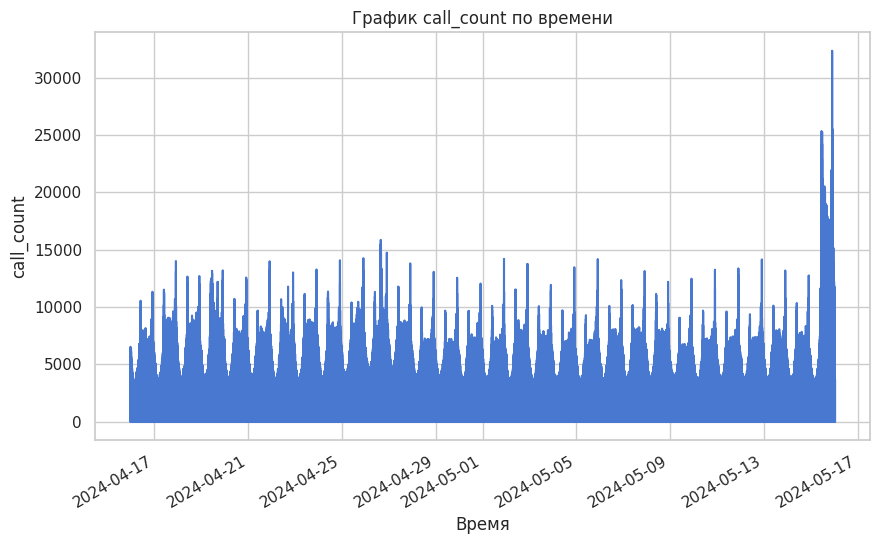

In [24]:
plot_data(df, 'call_count')

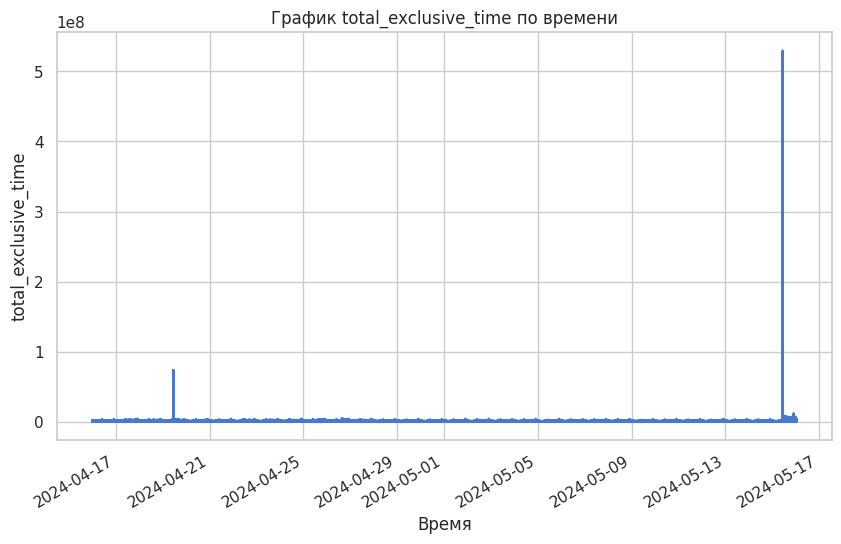

In [25]:
plot_data(df, 'total_exclusive_time')

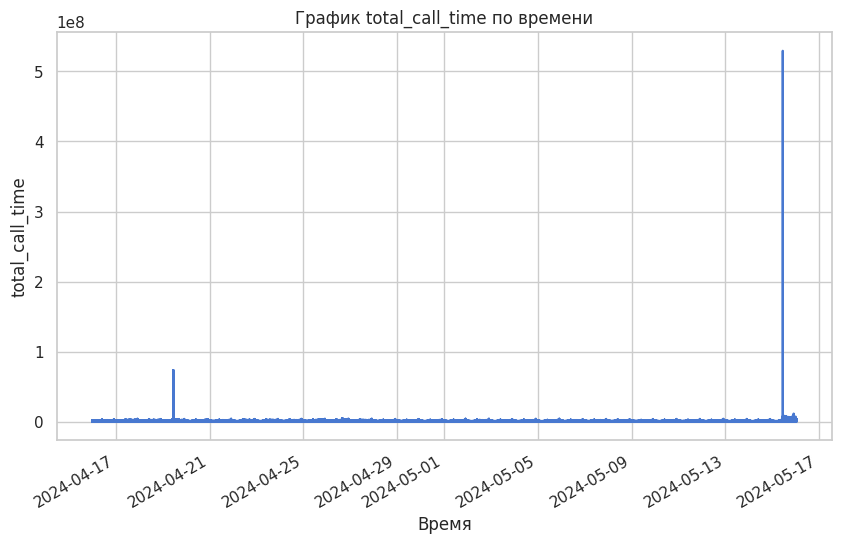

In [26]:
plot_data(df, 'total_call_time')

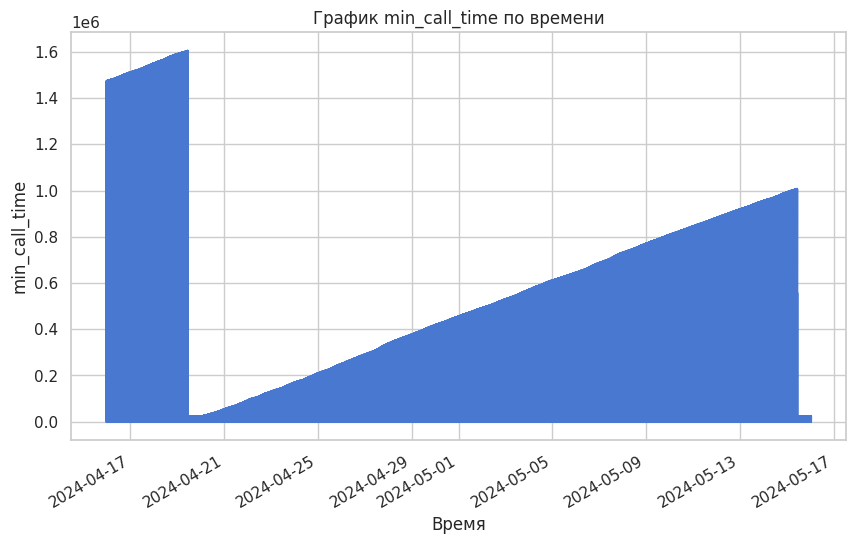

In [28]:
plot_data(df, 'min_call_time')

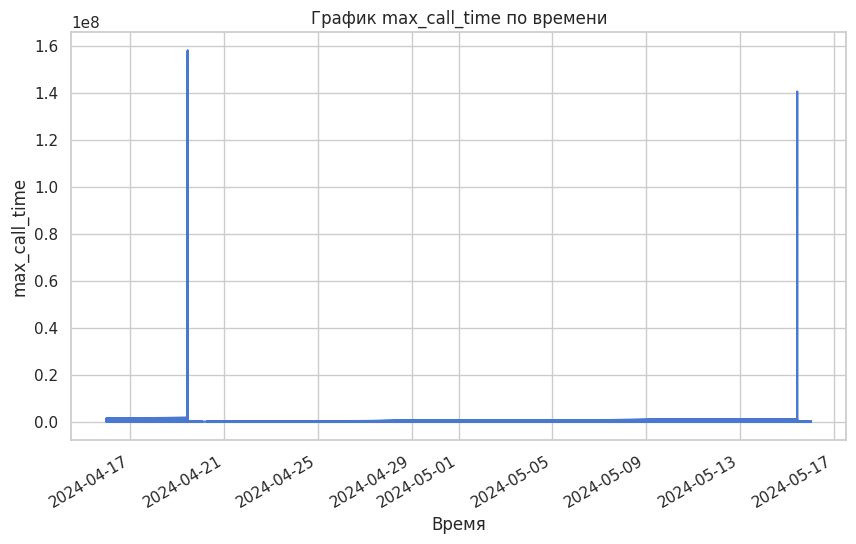

In [30]:
plot_data(df, 'max_call_time')

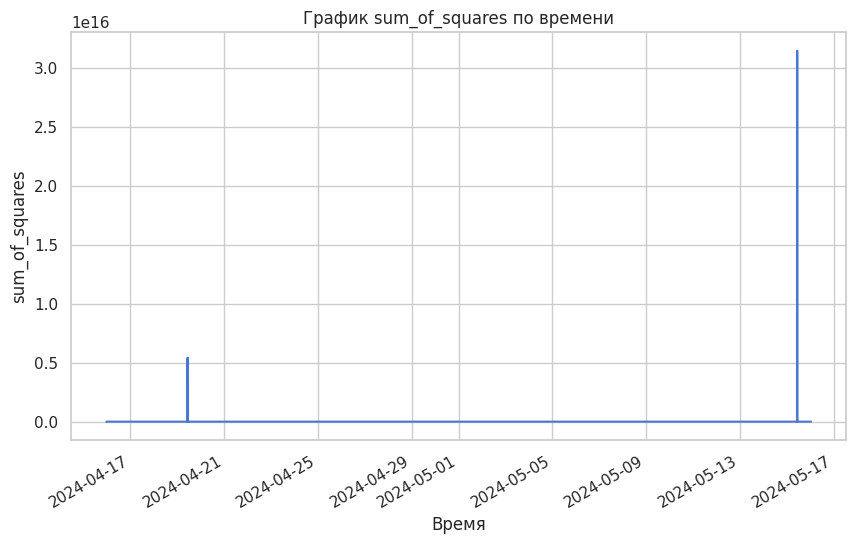

In [31]:
plot_data(df, 'sum_of_squares')

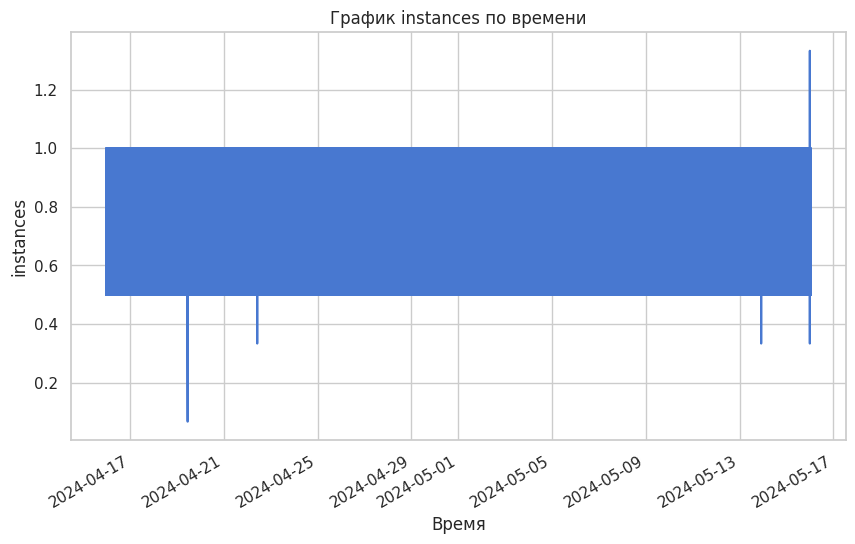

In [32]:
plot_data(df, 'instances')

### Графики и индикаторы

In [196]:
df.index = pd.to_datetime(df.index)

start_date = '2024-04-19 23:33:00'
end_date = '2024-04-21 23:33:00'

selected_df = df.loc[start_date:end_date]

In [197]:
selected_df['total_call_time'] = selected_df['total_call_time'].astype(float)

In [198]:
selected_df.shape

(1223827, 12)

In [199]:
selected_df = selected_df[selected_df['total_call_time'] > 1150000]
selected_df['total_call_time'].head()
selected_df.shape

(2372, 12)

In [ ]:
df = df.drop(['MACD', 'MACD_Diff'], axis=1)

In [201]:
selected_df.head(5)

,call_count,total_call_time,total_exclusive_time,min_call_time,max_call_time,sum_of_squares,instances,MACD,MACD_Signal,MACD_Diff,total_call_time_sma_5,SMA_change_total_call_time_5
point,,,,,,,,,,,,
2024-04-19 23:33:00,4195.0,2035491.0,2035491.0,201.0,36583.0,5.408571e+09,1.0,8859.696573,-10174.075543,19033.772115,2035491.0,-9641.0
2024-04-19 23:34:00,4363.0,2096969.0,2096969.0,201.0,36220.0,4.832825e+09,1.0,15880.438753,-4963.172684,20843.611436,2096969.0,61478.0
2024-04-19 23:35:00,4432.5,2113595.5,2113595.5,201.0,36220.0,4.802707e+09,1.0,22526.377056,534.737264,21991.639792,2113595.5,16626.5
2024-04-19 23:36:00,4300.5,2053526.0,2053526.0,201.0,31720.0,4.723840e+09,1.0,22684.728980,4964.735608,17719.993373,2053526.0,-60069.5
2024-04-19 23:37:00,4187.5,2021291.0,2021291.0,201.0,31720.0,4.883476e+09,1.0,19978.825456,7967.553577,12011.271879,2021291.0,-32235.0


In [193]:
def plot_data(dataset, fichas, threshold=1, markersize=1, linewidth=0.5):
    plt.figure(figsize=(10, 6))

    for ficha in fichas:
        filtered_data = dataset[dataset[ficha] >= threshold]
        plt.plot(filtered_data.index, filtered_data[ficha], marker='o',
                 markersize=markersize, linestyle='-', linewidth=linewidth,
                 label=ficha)

    plt.title('График нескольких фичей по времени')
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.grid(True)
    plt.legend()
    plt.show()

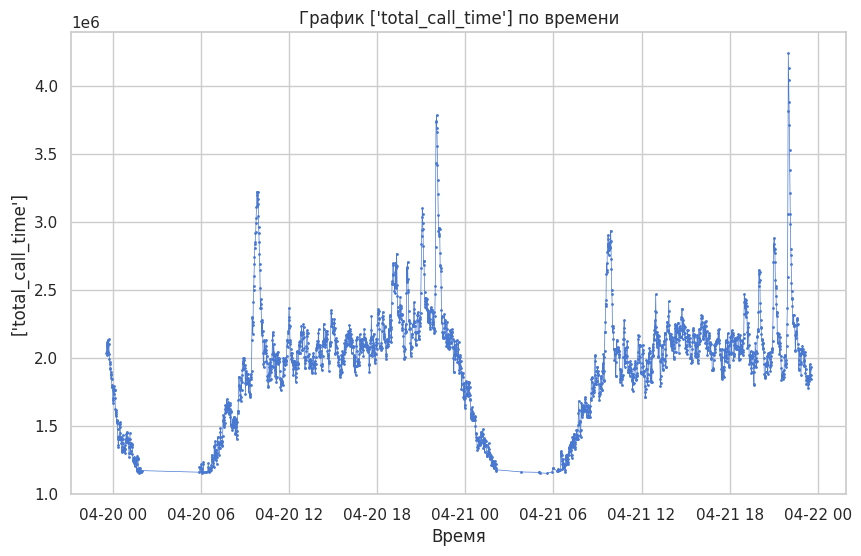

In [204]:
plot_data(selected_df, ['total_call_time'],
          threshold=0, markersize=1, linewidth=0.5)

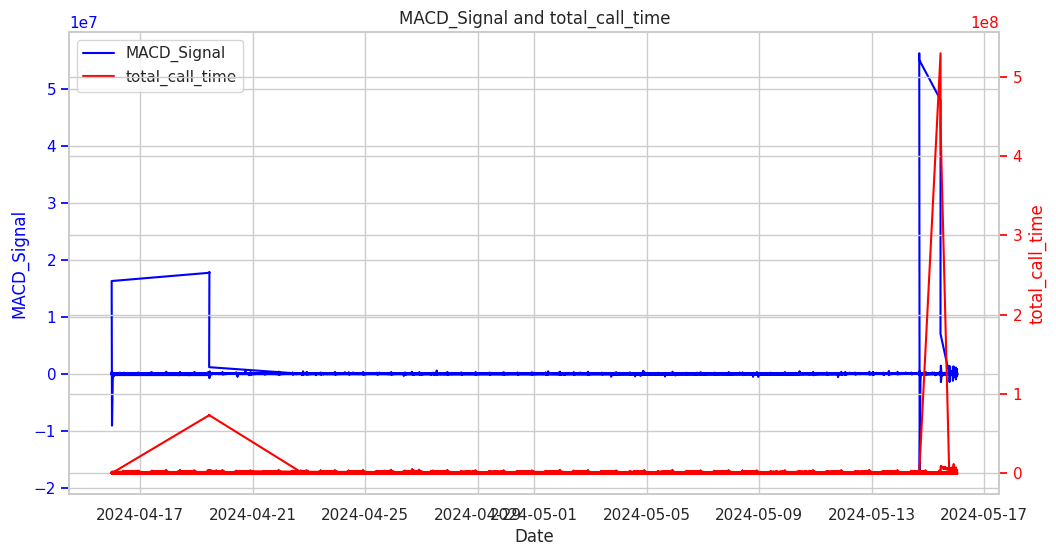

In [205]:
import matplotlib.pyplot as plt

# Получаем данные из датафрейма
x = df.index
macd_signal = df['MACD_Signal']
total_call_time = df['total_call_time']

# Создаем фигуру и две оси
fig, ax1 = plt.subplots(figsize=(12, 6))

# Строим график MACD_Signal на первой оси
ax1.plot(x, macd_signal, color='blue', label='MACD_Signal')
ax1.set_xlabel('Date')
ax1.set_ylabel('MACD_Signal', color='blue')
ax1.tick_params('y', colors='blue')

# Создаем вторую ось для total_call_time
ax2 = ax1.twinx()

# Строим график total_call_time на второй оси
ax2.plot(x, total_call_time, color='red', label='total_call_time')
ax2.set_ylabel('total_call_time', color='red')
ax2.tick_params('y', colors='red')

# Объединяем легенды
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Показываем график
plt.title('MACD_Signal and total_call_time')
plt.show()

In [ ]:
#1.1. Простое_скользящее_среднее (sma) и уклон
def add_indicators_sma(dataset):
    list_name_sma = ['5']
    list_wind_sma = [1]
    list_param = ['total_call_time']
    for par in range(len(list_param)):
        for itr in range(len(list_name_sma)):
            df[f'{list_param[par]}_sma_{list_name_sma[itr]}'] = ta.trend.sma_indicator(df[list_param[par]], window=list_wind_sma[itr])
            df[f'SMA_change_{list_param[par]}_{list_name_sma[itr]}'] = df[f'{list_param[par]}_sma_{list_name_sma[itr]}'].diff()
            df[f'Slope_SMA_change_{list_param[par]}_{list_name_sma[itr]}'] = np.arctan(dataset[f'SMA_change_{list_param[par]}_{list_name_sma[itr]}']).apply(np.rad2deg)

add_indicators(df)

In [74]:
# Функция для построения графика MACD
def plot_macd(dataframe, title):
    plt.figure(figsize=(12, 8))

    macd = ta.trend.MACD(df['total_call_time'])
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    df['MACD_Diff'] = macd.macd_diff()

    # Сигнальная линия MACD
    plt.plot(dataframe.index, dataframe['MACD'], label='MACD', color='blue')

    # Сигнальная линия MACD
    plt.plot(dataframe.index, dataframe['MACD_Signal'], label='MACD Signal Line', linestyle='--', color='red')

    # Разница MACD
    plt.fill_between(dataframe.index, dataframe['MACD'],
                     dataframe['MACD_Signal'],
                     where=(dataframe['MACD']>dataframe['MACD_Signal']),
                     interpolate=True, alpha=0.35, color='green')
    plt.fill_between(dataframe.index, dataframe['MACD'],
                     dataframe['MACD_Signal'],
                     where=(dataframe['MACD']<dataframe['MACD_Signal']),
                     interpolate=True, alpha=0.35, color='yellow')

    plt.title(title)
    plt.xlabel('Дата')
    plt.ylabel('MACD')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

# Построение графика MACD
plot_macd(selected_df, 'MACD, MACD Signal Line и MACD Difference')

KeyError: 'MACD'

<Figure size 1200x800 with 0 Axes>

## Алгоритмы

### МСП

In [ ]:
#device = tf.device("gpu:0" if tf.test.is_gpu_available() else "cpu:0")
#print(f"Используем устройство: {device}")

X = df.drop(['point'], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = Sequential()
model.add(Dense(32, input_dim=df.shape[1], activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(X_scaled.shape[1], activation='linear'))

model.compile(optimizer=Adam(learning_rate=0.01), loss=MeanSquaredError())

early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1)
tqdm_callback = TqdmCallback(verbose=1)

model.fit(X_scaled, X_scaled, epochs=15, batch_size=64, verbose=0,
          callbacks=[tqdm_callback, early_stopping])

### CNN

In [ ]:
#device = tf.device("gpu:0" if tf.test.is_gpu_available() else "cpu:0")
#print(f"Используем устройство: {device}")

X = df.drop(['point'], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',
                 input_shape=(X_scaled.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(X_scaled.shape[1], activation='linear'))

model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1)
tqdm_callback = TqdmCallback(verbose=1)

model.fit(X_scaled.reshape(-1, X_scaled.shape[1], 1), X_scaled,
          epochs=15, batch_size=64, verbose=0,
          callbacks=[tqdm_callback, early_stopping])

### RNN

In [ ]:
#device = tf.device("gpu:0" if tf.test.is_gpu_available() else "cpu:0")
#print(f"Используем устройство: {device}")

X = df.drop(['point'], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = Sequential()
model.add(LSTM(32, input_shape=(X_scaled.shape[1], 1), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(X_scaled.shape[1], activation='linear'))

model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1)
tqdm_callback = TqdmCallback(verbose=1)

model.fit(X_scaled.reshape(-1, X_scaled.shape[1], 1), X_scaled, epochs=15,
          batch_size=64, verbose=0,
          callbacks=[tqdm_callback, early_stopping])

### Автокодировщик (Autoencoder) (+)

In [ ]:
#device = tf.device("gpu:0" if tf.test.is_gpu_available() else "cpu:0")
#print(f"Используем устройство: {device}")

import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

X = df.drop(['point'], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

input_dim = X_scaled.shape[1]
encoding_dim = int(input_dim / 2)

model = Sequential()
model.add(Input(shape=(input_dim,)))
model.add(Dense(encoding_dim, activation='relu'))
model.add(Dense(input_dim, activation='linear'))

model.compile(optimizer=Adam(), loss='mean_squared_error')

tqdm_callback = TqdmCallback(verbose=1)
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=1)
callbacks = [tqdm_callback, early_stopping, lr_scheduler]

model.fit(X_scaled, X_scaled, epochs=10, batch_size=64, callbacks=callbacks)

X_reconstructed = model.predict(X_scaled)
reconstruction_error = ((X_scaled - X_reconstructed) ** 2).mean(axis=1)

df['reconstruction_error'] = reconstruction_error

# Print the results
print(df)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10
286934/286934 [==============================] - 659s 2ms/step - loss: 0.5717 - lr: 0.0010
Epoch 2/10
286934/286934 [==============================] - 692s 2ms/step - loss: 0.5597 - lr: 0.0010
Epoch 3/10
286934/286934 [==============================] - 658s 2ms/step - loss: 0.5396 - lr: 0.0010
Epoch 4/10
286934/286934 [==============================] - 659s 2ms/step - loss: 0.5330 - lr: 0.0010
Epoch 5/10
286934/286934 [==============================] - 650s 2ms/step - loss: 0.5318 - lr: 0.0010
Epoch 6/10
286934/286934 [==============================] - 679s 2ms/step - loss: 0.5515 - lr: 0.0010
Epoch 7/10
121256/286934 [===========>..................] - ETA: 6:40 - loss: 0.1554

In [ ]:
reconstructed = model.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructed, 2), axis=1)
threshold = np.mean(mse) + 2 * np.std(mse)
anomalies = mse > threshold

df['anomaly'] = anomalies.astype(int)
print(df)

unique_values = df['anomaly'].unique()
print(f"Уникальные значения в колонке 'anomaly': {unique_values}")

count_0 = df[df['anomaly'] == 0].shape[0]
count_1 = df[df['anomaly'] == 1].shape[0]

print(f"Количество значений 0: {count_0}")
print(f"Количество значений 1: {count_1}")

df_0 = df[df['is_anomaly_simple'] == 0]
df_1 = df[df['is_anomaly_simple'] == 1]

print(df_1['point'])

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_1['point'], [0] * len(df_1), 'ro', markersize=5)
plt.xlabel('Время')
plt.ylabel('Значение')
plt.title('Распределение значений по времени для класса 1')
plt.show()

df = df.drop('is_anomaly_simple', axis=1)

### Вариационный автокодировщик (Variational Autoencoder, VAE)

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K

# Преобразование 'point' в datetime
df['point'] = pd.to_datetime(df['point'])

# Нормализация данных
X = df[['call_count', 'total_call_time', 'total_exclusive_time', 'min_call_time', 'max_call_time', 'sum_of_squares', 'instances']].values
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Определение параметров модели
input_dim = X.shape[1]
latent_dim = 2  # Размерность латентного пространства

# Построение модели
inputs = Input(shape=(input_dim,))
z_mean = Dense(latent_dim, name='z_mean')(inputs)
z_log_var = Dense(latent_dim, name='z_log_var')(inputs)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=1.0)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Декодер
decoder_hidden = Dense(64, activation='relu')(z)
outputs = Dense(input_dim, activation='linear')(decoder_hidden)

# Определение модели
vae = Model(inputs, outputs)

# Определение функции потерь для вариационного автокодировщика
def vae_loss(inputs, outputs):
    reconstruction_loss = K.mean(K.square(inputs - outputs))
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return reconstruction_loss + kl_loss

# Компиляция модели
vae.compile(optimizer=Adam(lr=0.001), loss=vae_loss)

# Обучение модели
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('best_vae_model.h5', monitor='loss', save_best_only=True, verbose=1)
vae.fit(X, X, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

TypeError: Exception encountered when calling layer "z" (type Lambda).

Input 'y' of 'Mul' Op has type float32 that does not match type float16 of argument 'x'.

Call arguments received by layer "z" (type Lambda):
  • inputs=['tf.Tensor(shape=(None, 2), dtype=float16)', 'tf.Tensor(shape=(None, 2), dtype=float16)']
  • mask=None
  • training=None

### Глубокая нейронная сеть с рекуррентным звеном (Deep Neural Network with Recurrent Layers) (на примере LSTM)

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Преобразование 'point' в datetime
df['point'] = pd.to_datetime(df['point'])

# Подготовка данных
X = df[['call_count', 'total_call_time', 'total_exclusive_time',
        'min_call_time', 'max_call_time', 'sum_of_squares', 'instances']].values
y = df['call_count'].values

# Нормализация данных
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

# Reshape данных для LSTM
X = X.reshape(X.shape[0], 1, X.shape[1])

# Определение параметров модели
input_dim = X.shape[2]
output_dim = 1
seq_length = 1
lstm_units = 64
dropout_rate = 0.2

# Построение модели
model = Sequential()
model.add(LSTM(lstm_units, input_shape=(seq_length, input_dim), return_sequences=False))
model.add(Dropout(dropout_rate))
model.add(Dense(output_dim, activation='linear'))

# Компиляция модели
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')

# Обучение модели
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('best_lstm_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: nan
Epoch 1: val_loss did not improve from inf
1/1 [==============================] - 5s 5s/step - loss: nan - val_loss: nan
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: nan
Epoch 2: val_loss did not improve from inf
1/1 [==============================] - 0s 97ms/step - loss: nan - val_loss: nan
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: nan
Epoch 3: val_loss did not improve from inf
1/1 [==============================] - 0s 76ms/step - loss: nan - val_loss: nan
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: nan
Epoch 4: val_loss did not improve from inf
1/1 [==============================] - 0s 79ms/step - loss: nan - val_loss: nan
Epoch 5/100
1/1 [==============================] - ETA: 0s - loss: nan
Epoch 5: val_loss did not improve from inf
1/1 [==============================] - 0s 50ms/step - loss: nan - val_loss: nan
Epoch 6/100
1/1 [===============

### Комбинированная модель (Hybrid Model) (CNN + LSTM) (+)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout, BatchNormalization

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Преобразование 'point' в datetime
df['point'] = pd.to_datetime(df['point'])

# Подготовка данных
X = df[['call_count', 'total_call_time', 'total_exclusive_time',
        'min_call_time', 'max_call_time', 'sum_of_squares', 'instances']].values
y = df['call_count'].values

# Нормализация данных
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

# Reshape данных для CNN и LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Определение параметров модели
input_shape = (X.shape[1], 1)
output_dim = 1
cnn_filters = 32
cnn_kernel_size = 3
lstm_units = 64
dropout_rate = 0.2

# Построение модели
model = Sequential()
model.add(Conv1D(filters=cnn_filters, kernel_size=cnn_kernel_size, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(lstm_units, return_sequences=False))
model.add(Dropout(dropout_rate))
model.add(Dense(output_dim, activation='linear'))

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Обучение модели
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('best_hybrid_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
model.fit(X, y, epochs=100,
          batch_size=16,
          validation_split=0.2,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.5347
Epoch 1: val_loss improved from inf to 0.35962, saving model to best_hybrid_model.h5
1/1 [==============================] - 7s 7s/step - loss: 0.5347 - val_loss: 0.3596
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3550
Epoch 2: val_loss did not improve from 0.35962
1/1 [==============================] - 0s 79ms/step - loss: 0.3550 - val_loss: 0.3596
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.4829
Epoch 3: val_loss did not improve from 0.35962
1/1 [==============================] - 0s 102ms/step - loss: 0.4829 - val_loss: 0.3596
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.7217
Epoch 4: val_loss did not improve from 0.35962
1/1 [==============================] - 0s 93ms/step - loss: 0.7217 - val_loss: 0.3596
Epoch 5/100
1/1 [==============================] - ETA: 0s - loss: 0.4551
Epoch 5: val_loss did not improve from 0.35962
1/1 [=========

## LSTM

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
#device = tf.device("gpu:0" if tf.test.is_gpu_available() else "cpu:0")
#print(f"Используем устройство: {device}")

df['point'] = pd.to_datetime(df['point'])

X = df[['call_count', 'total_call_time', 'total_exclusive_time',
        'min_call_time', 'max_call_time', 'sum_of_squares',
        'instances']].values.reshape(len(df), 1, 7)
y = df['point'].values

model = Sequential()
model.add(LSTM(64, input_shape=(1, 7), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(lr=0.001), loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

model.fit(X, y, epochs=5, batch_size=32, verbose=1, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported numpy type: NPY_DATETIME).

## Построение_индикаторов_для_обрезки_датасета

In [ ]:
df_isolation = df.set_index('point')

In [ ]:
# Нам в модель не надо брать все данные надо только чувствительные участки



In [ ]:
def add_indicators(dataset):

    #1.3. Система направленного движения (average directional movement index)
    adx_indicator = ADXIndicator(df['high'], df['low'], df['price'], 2, False)
    df['+DI'] = adx_indicator.adx_pos()
    df['-DI'] = adx_indicator.adx_neg()
    #df_analysis['ADX'] = adx_indicator.adx() ###!!!

    #1.4. Cкользящая средняя по корпусу (the hull moving average)
    def WMA(s, period):
        return s.rolling(period).apply(lambda x: ((np.arange(period)+1)*x).sum()/(np.arange(period)+1).sum(), raw=True)
    def HMA(s, period):
        return WMA(WMA(s, period//2).multiply(2).sub(WMA(s, period)), int(np.sqrt(period)))
    df['hma'] = HMA(dataset['price'], 10)

    #1.5. Стохастический осциллятор (stochastic oscillator)
    df['stoch'] = ta.momentum.StochasticOscillator(df['high'], df['low'], df['price']).stoch()

    #1.6. Облако Ichimoku (Ichimoku cloud)
    df['ichimoku_tenkan'] = ta.trend.ichimoku_base_line(df['high'], df['low'], window1=9, window2=26, fillna=True)
    df['ichimoku_kijun'] = ta.trend.ichimoku_conversion_line(df['high'], df['low'], window2=26, fillna=True)
    df['ichimoku_senkou_a'] = ta.trend.ichimoku_a(df['high'], df['low'], window2=26, fillna=True)
    df['ichimoku_senkou_b'] = ta.trend.ichimoku_b(df['high'], df['low'], window2=26, fillna=True)

    #1.7. Williams %R (williams_%r)
    period = 5
    highest_high = df['high'].rolling(period).max()
    lowest_low = df['low'].rolling(period).min()
    close = df['price']
    williams_r = (highest_high - close) / (highest_high - lowest_low) * -100
    df['williams_%r'] = williams_r

    return dataset

df = add_indicators(df)

#### 1. Robust Covariance

In [ ]:
#df.to_feather('/content/drive/MyDrive/Hackatons/RedLab_Anomaly_Detection/metrics_collector.feather')

In [ ]:
# Применение Robust Covariance для обнаружения аномалий
X = df[['call_count', 'total_call_time',
        'total_exclusive_time', 'min_call_time',
        'max_call_time', 'sum_of_squares', 'instances']].values
clf = EllipticEnvelope(contamination=0.5)

with tqdm(total=len(X), desc="Processing data") as pbar:
    y_pred = clf.fit_predict(X)
    pbar.update(len(X))

# Определение аномальных объектов
outliers_mask = (y_pred == -1)
print("Аномальные объекты:")
print(df.loc[outliers_mask])

Processing data:   0%|          | 0/18363749 [00:26<?, ?it/s]


KeyboardInterrupt: 

#### 1. IsolationForest

In [ ]:
df_isolation = df.set_index('point')

In [ ]:
%time
# сделать подбор оптимального contamination !!!
clf = IsolationForest(contamination=0.5)

with tqdm(total=len(X), desc="Processing data") as pbar:
    y_pred = clf.fit_predict(X)
    pbar.update(len(X))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


NameError: name 'X' is not defined

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(df.index, y_pred, c=y_pred, cmap='viridis')
plt.title('Isolation Forest Anomaly Detection')
plt.xlabel('Index')
plt.ylabel('Anomaly Score')
plt.show()

In [ ]:
del df_isolation

#### 2. OneClassSVM

In [ ]:
from sklearn.svm import OneClassSVM

In [ ]:
# Подготовка данных
X = df.drop(['point'], axis=1).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Обучение модели OC-SVM
clf = OneClassSVM(nu=0.01, kernel='rbf', gamma='auto')
clf.fit(X_scaled)

In [ ]:
# Определение аномалий
anomalies = clf.predict(X_scaled)

# Вывод результатов
df['is_anomaly'] = anomalies
print(df)

#### 4. Автокодировщики (Autoencoders) - Advanced

In [ ]:
with device:
    model = Sequential()

    # layer_1
    model.add(Dense(16, input_dim=X_scaled.shape[1],
                    activation=LeakyReLU()))
    model.add(BatchNormalization())
    model.add(Dropout(0.05))

    # layer_2
    model.add(Dense(8, activation=LeakyReLU()))
    model.add(BatchNormalization())
    model.add(Dropout(0.05))

    # layer_3
    model.add(Dense(16, activation=LeakyReLU()))
    model.add(BatchNormalization())
    model.add(Dropout(0.03))

    # layer_4
    model.add(Dense(X_scaled.shape[1], activation='linear'))
    model.compile(optimizer=Adam(learning_rate=0.1), loss=MeanSquaredError())

    early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1)
    tqdm_callback = TqdmCallback(verbose=1)
    model.fit(X_scaled, X_scaled, epochs=15,
              batch_size=64, verbose=0,
              callbacks=[tqdm_callback, early_stopping])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
# Определение аномалий
reconstructed = model.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructed, 2), axis=1)
threshold = np.mean(mse) + 2 * np.std(mse)
anomalies = mse > threshold

# Вывод результатов
df['is_anomaly_advanced'] = anomalies.astype(int)
print(df)

In [ ]:
unique_values = df['is_anomaly_advanced'].unique()
print(unique_values)

In [ ]:
unique_values = df['is_anomaly_advanced'].unique()
print(f"Уникальные значения в колонке 'is_anomaly_simple': {unique_values}")

# Подсчет количества значений 0 и 1
count_0 = df[df['is_anomaly_advanced'] == 0].shape[0]
count_1 = df[df['is_anomaly_advanced'] == 1].shape[0]

print(f"Количество значений 0: {count_0}")
print(f"Количество значений 1: {count_1}")

In [ ]:
df_0 = df[df['is_anomaly_advanced'] == 0]
df_1 = df[df['is_anomaly_advanced'] == 1]

In [ ]:
print(df_1['point'])

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_1['point'], [0] * len(df_1), 'ro', markersize=5)
plt.xlabel('Время')
plt.ylabel('Значение')
plt.title('Распределение значений по времени для класса 1')
plt.show()

#### 4. Local Outlier Factor (LOF)

#### 2. Darts

In [ ]:
!pip show darts

In [ ]:
import darts
from darts.models import HoltWintersModel

In [ ]:
df.head().T

In [ ]:
df.info()

In [ ]:
import pandas as pd
from darts import TimeSeries
from darts.models import HoltWintersModel
#from darts.models.anomaly_detection.darts_detector import DartsDetector

In [ ]:
import pandas as pd
from darts import TimeSeries
from darts.models.forecasting.holtwinters_model import HoltWintersModel
from darts.models.anomaly_detection.darts_detector import DartsDetector

# Загружаем данные в Darts TimeSeries
df = pd.DataFrame(df, index=pd.date_range("2024-04-15 23:33:00", periods=5, freq="1min"))

ts = TimeSeries.from_dataframe(df, time_col_name="index")

# Обучаем модель Хольта-Винтерса
model = HoltWintersModel()
model.fit(ts)

# Создаем детектор аномалий Darts
detector = DartsDetector(model)

# Обнаруживаем аномалии
anomalies = detector.find_anomalies(ts)

# Выводим результаты
print("Обнаруженные аномалии:")
for anomaly in anomalies:
    print(f"Дата: {anomaly.time}, Значение: {anomaly.value}")

In [ ]:
df = df

# Преобразование DataFrame в объект TimeSeries
time_series = TimeSeries.from_dataframe(df, 'timestamp', 'value')  # Замените 'timestamp' и 'value' на соответствующие столбцы

# Масштабирование данных (необязательно)
scaler = Scaler()
scaled_time_series = scaler.fit_transform(time_series)

# Разделение данных на тренировочные и валидационные наборы
train, val = scaled_time_series.split_before(0.6)

In [ ]:
scorer = KMeansScorer(k=2, window=5)
scorer.fit(train)
anom_score = scorer.score(val)

In [ ]:
detector = QuantileDetector(high_quantile=0.99)
detector.fit(scorer.score(train))
binary_anom = detector.detect(anom_score)

In [ ]:
series.plot()
(anom_score / 2. - 100).plot(label="computed anomaly score", c="orangered", lw=3)
(binary_anom * 45 - 150).plot(label="detected binary anomaly", lw=4)

#### 3. PyPots

In [ ]:
import numpy as np
from pypots.univariate import SPOT

# Создаем экземпляр детектора аномалий SPOT
detector = SPOT()

# Извлекаем значения столбца 'call_count' в виде массива NumPy
data = df['call_count'].values

# Применяем алгоритм SPOT для поиска аномалий
anomalies = detector.fit_detect(data)

# Отобразить результаты
for i, is_anomaly in enumerate(anomalies):
    if is_anomaly:
        print(f"Аномалия обнаружена в точке {df.index[i]}")
    else:
        print(f"Нормальное значение в точке {df.index[i]}")

In [ ]:
# Сохраняем DataFrame в файл CSV
df.to_csv('/content/drive/MyDrive/Hackatons/RedLab_Anomaly_Detection/metrics_collector_v_01.csv', index=False)
print("Данные успешно сохранены в файл CSV.")

## PyPots

In [ ]:
# Data preprocessing. Tedious, but PyPOTS can help.

data = load_specific_dataset('physionet_2012')  # PyPOTS will automatically download and extract it.
X = data['X']
num_samples = len(X['RecordID'].unique())
X = X.drop(['RecordID', 'Time'], axis = 1)
X = StandardScaler().fit_transform(X.to_numpy())
X = X.reshape(num_samples, 48, -1)
X_ori = X  # keep X_ori for validation
X = mcar(X, 0.1)  # randomly hold out 10% observed values as ground truth
dataset = {"X": X}  # X for model input
print(X.shape)  # (11988, 48, 37), 11988 samples and each sample has 48 time steps, 37 features

# Model training. This is PyPOTS showtime.
from pypots.imputation import SAITS
from pypots.utils.metrics import calc_mae
saits = SAITS(n_steps=48, n_features=37, n_layers=2, d_model=256, n_heads=4, d_k=64, d_v=64, d_ffn=128, dropout=0.1, epochs=10)
# Here I use the whole dataset as the training set because ground truth is not visible to the model, you can also split it into train/val/test sets
saits.fit(dataset)  # train the model on the dataset
imputation = saits.impute(dataset)  # impute the originally-missing values and artificially-missing values
indicating_mask = np.isnan(X) ^ np.isnan(X_ori)  # indicating mask for imputation error calculation
mae = calc_mae(imputation, np.nan_to_num(X_ori), indicating_mask)  # calculate mean absolute error on the ground truth (artificially-missing values)
saits.save("save_it_here/saits_physionet2012.pypots")  # save the model for future use
saits.load("save_it_here/saits_physionet2012.pypots")  # reload the serialized model file for following imputation or training

## Transformer-based Autoencoder with contrastive learning and Generative Adversarial Networks (GAN)

In [ ]:
# Load the dataset
data = pd.read_csv('creditcard.csv')

In [ ]:
# Check for missing values in the 'Class' column
print("Missing values in 'Class' column:", data['Class'].isnull().sum())

In [ ]:
# Drop rows where 'Class' is NaN
data = data.dropna(subset=['Class'])

In [ ]:
# Re-check to confirm no more NaNs in 'Class'
print("Missing values in 'Class' column after dropping rows:", data['Class'].isnull().sum())

In [ ]:
# Normalize 'Time' and 'Amount' using StandardScaler
scaler = StandardScaler()
data['NormalizedTime'] = scaler.fit_transform(data[['Time']])
data['NormalizedAmount'] = scaler.fit_transform(data[['Amount']])
data.drop(['Time', 'Amount'], axis=1, inplace=True)

In [ ]:
# Split the dataset
X = data.drop('Class', axis=1)
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Data Augmentation with Geometric Distribution Masks

In [ ]:
def apply_geometric_mask(data, mask_prob=0.1):
    mask = np.random.geometric(p=mask_prob, size=data.shape)
    masked_data = np.where(mask > 1, data, 0)  # Apply mask where mask > 1
    return masked_data

# Apply masks to the training data
X_train_masked = apply_geometric_mask(X_train.values)

#### Transformer-Based Autoencoder

In [ ]:
class TransformerAutoencoder(nn.Module):
    def __init__(self, input_size, feature_size=256, num_heads=4, num_layers=1, forward_expansion=4, dropout=0.1):
        super(TransformerAutoencoder, self).__init__()
        # Ensure feature_size is a multiple of num_heads
        assert feature_size % num_heads == 0, "feature_size must be divisible by num_heads"

        self.embedding = nn.Linear(input_size, feature_size)  # Adjust input feature size to transformer feature size
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=feature_size,
            nhead=num_heads,
            dim_feedforward=feature_size * forward_expansion,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=feature_size,
            nhead=num_heads,
            dim_feedforward=feature_size * forward_expansion,
            dropout=dropout,
            batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(feature_size, input_size)  # Map back to the original input size

    def forward(self, src):
        src = self.embedding(src)  # Embed input features
        encoded = self.encoder(src)
        decoded = self.decoder(encoded, encoded)
        output = self.output_layer(decoded)  # Map back to original feature space
        return output

# Use this to initialize your model
input_size = X_train.shape[1]
feature_size = 256  # Choose a feature size that is a multiple of num_heads
num_heads = 4
model = TransformerAutoencoder(input_size, feature_size, num_heads).to(device)

In [ ]:
# Assuming X_train_masked and y_train are already defined and appropriately processed
train_dataset = TensorDataset(torch.tensor(X_train_masked, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
import torch.optim as optim

criterion = nn.MSELoss()  # For reconstruction loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

epoch_losses = []

def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, _ in train_loader:  # Labels are not used during training
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            avg_loss=total_loss / len(train_loader)
            epoch_losses.append(avg_loss)
        print(f'Epoch {epoch+1}, Average Loss: {avg_loss}')

train_model(model, train_loader, criterion, optimizer)

In [ ]:
# Plotting the training losses
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, marker='o', linestyle='-')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

#### GAN

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

class Generator(nn.Module):
    def __init__(self, autoencoder_model):
        super(Generator, self).__init__()
        self.autoencoder = autoencoder_model

    def forward(self, x):
        return self.autoencoder(x)

#### Contrastive Loss for Anomoly Detection

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output, target, label):
        euclidean_distance = torch.nn.functional.pairwise_distance(output, target)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

#### Train GAN alongside with AutoEncoder

In [ ]:
def train_gan_autoencoder(autoencoder, generator, discriminator, data_loader, epochs=10):
    # Optimizers
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.001)
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.001)
    optimizer_AE = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

    adversarial_loss = torch.nn.BCELoss()

    for epoch in range(epochs):
        for i, (imgs, _) in enumerate(data_loader):

            valid = torch.ones(imgs.size(0), 1, device=device, dtype=torch.float32)
            fake = torch.zeros(imgs.size(0), 1, device=device, dtype=torch.float32)

            # -----------------
            #  Train Generator
            # -----------------
            optimizer_G.zero_grad()
            z = torch.randn(imgs.shape[0], imgs.shape[1], device=device)
            gen_imgs = generator(z)
            g_loss = adversarial_loss(discriminator(gen_imgs), valid)
            g_loss.backward()
            optimizer_G.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # ---------------------
            #  Train Autoencoder
            # ---------------------
            optimizer_AE.zero_grad()
            reconstructed_imgs = autoencoder(imgs)
            ae_loss = torch.nn.functional.mse_loss(reconstructed_imgs, imgs)
            ae_loss.backward()
            optimizer_AE.step()

            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [AE loss: %f]" %
                  (epoch, epochs, i, len(data_loader), d_loss.item(), g_loss.item(), ae_loss.item()))

In [ ]:
# Device setup: CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Corrected input size
input_dim = 30  # Based on the shape of the data in your DataLoader

# Initialize models with correct input dimension
autoencoder_model = AutoencoderWithTransformer(input_size=input_dim, hidden_size=64, num_enc_layers=2, num_heads=1)
generator = Generator(autoencoder_model)
discriminator = Discriminator(input_dim=input_dim)

# Move models to the appropriate device
autoencoder_model.to(device)
generator.to(device)
discriminator.to(device)

# Data loader (assuming X_train_masked and y_train are available)
train_loader = DataLoader(TensorDataset(torch.tensor(X_train_masked, dtype=torch.float32),
                                        torch.tensor(y_train.values, dtype=torch.float32)),
                          batch_size=32, shuffle=True)

# Call the training function with the correct input size for discriminator
train_gan_autoencoder(autoencoder=autoencoder_model,
                      generator=generator,
                      discriminator=discriminator,
                      data_loader=train_loader,
                      epochs=10)  # Adjust the number of epochs as needed

## TimeEval

In [ ]:
pip install TimeEval

In [ ]:
from pathlib import Path
from typing import Dict, Any

import numpy as np

from timeeval import TimeEval, DatasetManager, Algorithm, TrainingType, InputDimensionality
from timeeval.adapters import FunctionAdapter
from timeeval.algorithms import subsequence_if
from timeeval.params import FixedParameters

# Load dataset metadata
dm = DatasetManager(Path("tests/example_data"), create_if_missing=False)


# Define algorithm
def my_algorithm(data: np.ndarray, args: Dict[str, Any]) -> np.ndarray:
    score_value = args.get("score_value", 0)
    return np.full_like(data, fill_value=score_value)


# Select datasets and algorithms
datasets = dm.select()
datasets = datasets[-1:]
# Add algorithms to evaluate...
algorithms = [
    Algorithm(
        name="MyAlgorithm",
        main=FunctionAdapter(my_algorithm),
        data_as_file=False,
        training_type=TrainingType.UNSUPERVISED,
        input_dimensionality=InputDimensionality.UNIVARIATE,
        param_config=FixedParameters({"score_value": 1.})
    ),
    subsequence_if(params=FixedParameters({"n_trees": 50}))
]
timeeval = TimeEval(dm, datasets, algorithms)

# execute evaluation
timeeval.run()
# retrieve results
print(timeeval.get_results())

## DS-Lab-II

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial.distance import euclidean
from joblib import Parallel, delayed
from fastdtw import fastdtw
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score,accuracy_score,classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
attack_df = pd.read_csv('/content/drive/My Drive/swat/SWaT_Dataset_Normal_v0.csv')
normal_df = pd.read_csv('/content/drive/My Drive/swat/SWaT_Dataset_Attack_v0.csv')

In [ ]:
# Combine the datasets
combined_df = pd.concat([normal_df, attack_df], ignore_index=True)

In [ ]:
print(combined_df.shape)
combined_df.head()

In [ ]:
combined_df['Normal/Attack'].unique()

In [ ]:
combined_df.info()

In [ ]:
combined_df['Normal/Attack'] = combined_df['Normal/Attack'].str.replace(' ', '')

In [ ]:
combined_df['Normal/Attack'].unique()

In [ ]:
class_distribution = combined_df['Normal/Attack'].value_counts()

In [ ]:
plt.figure(figsize=(4, 4))
plt.pie(class_distribution, labels=class_distribution.index, explode=[0, 0.2], autopct='%1.1f%%', colors=['g', 'r'])
plt.title('Distribution: Attack vs Normal')
plt.show()

In [ ]:
combined_df['Timestamp'] = combined_df['Timestamp'].str.strip()

try:
    combined_df['Timestamp'] = pd.to_datetime(combined_df['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')
except ValueError:
    combined_df['Timestamp'] = pd.to_datetime(combined_df['Timestamp'], infer_datetime_format=True, dayfirst=True)

In [ ]:
combined_df = combined_df.set_index('Timestamp')

In [ ]:
combined_df.head()

In [ ]:
attack_data = combined_df[combined_df['Normal/Attack'] == 'Attack']

In [ ]:
# List of all sensors and actuators in the first stage
first_stage_features = ['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201']

# Number of features
num_features = len(first_stage_features)

# Create subplots
fig, axes = plt.subplots(num_features, 1, figsize=(12, 2 * num_features), sharex=True)

# Plot each feature in a separate subplot
for i, feature in enumerate(first_stage_features):
    axes[i].plot(combined_df.index, combined_df[feature], label=feature)
    axes[i].scatter(attack_data.index, attack_data[feature], color='red', marker='x', label='Attack')
    axes[i].set_ylabel(feature)
    axes[i].legend()

plt.xlabel('Timestamp')
plt.suptitle('Subplots with Attack Markers for First-Stage Sensors and Actuators')
plt.show()

In [ ]:
combined_df.dropna(inplace=True)
combined_df.drop_duplicates(inplace=True)

combined_df.shape

In [ ]:
combined_df=combined_df.loc[:, combined_df.nunique() > 1]

In [ ]:
combined_df.loc[:, 'Normal/Attack'] = combined_df['Normal/Attack'].apply(lambda x: 1 if x == 'Attack' else 0)

In [ ]:
combined_df.head()

In [ ]:
X = combined_df.drop('Normal/Attack', axis=1)
y= combined_df['Normal/Attack']
y = y.reset_index(drop=True)

In [ ]:
# Saparate Numerical and categorical features
numerical_features = []
categorical_features = []

for column in X.columns:
    unique_values = X[column].nunique()
    if unique_values > 10:
        numerical_features.append(column)
    else:
        categorical_features.append(column)

In [ ]:
print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

In [ ]:
numerical_data = combined_df[numerical_features]
categorical_data = combined_df[categorical_features]

# Min-Max scaling for numerical features
scaler = MinMaxScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data)
numerical_data_scaled_df = pd.DataFrame(numerical_data_scaled, columns=numerical_data.columns)

In [ ]:
# One-hot encoding for categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoder.fit(categorical_data)

categorical_feature_names = encoder.get_feature_names_out(categorical_data.columns)
categorical_data_encoded = encoder.transform(categorical_data)
categorical_data_encoded_df = pd.DataFrame(categorical_data_encoded, columns=categorical_feature_names)

In [ ]:
preprocessed_data = pd.concat([numerical_data_scaled_df, categorical_data_encoded_df,y], axis=1)

In [ ]:
preprocessed_data.head()

In [ ]:
# Saving preprocessed data to a local drive
preprocessed_data.to_csv('/content/drive/My Drive/swat/preprocessed_data.csv', index=False)

In [ ]:
SWAT_prep = pd.read_csv('/content/drive/My Drive/swat/preprocessed_data.csv')

In [ ]:
sensors=['FIT101','LIT101']

In [ ]:
X=SWAT_prep

In [ ]:
SWAT_prep

In [ ]:
sampled_data = X.sample(n=3000, random_state=42)
sampled_data = sampled_data.astype(np.float64)

In [ ]:
sampled_data_dtw=sampled_data[sensors]

In [ ]:
sampled_data_dtw

In [ ]:
dtw_columns = sampled_data.columns

In [ ]:
def calculate_dtw_distance(s1, s2):
    distance, _ = fastdtw(s1, s2)
    return distance

In [ ]:
def calculate_dtw_parallel(row, df, dtw_columns):
    current_seq = row[dtw_columns].values.flatten()
    distances = []

    for idx, r in df.iterrows():
        if row.name != idx:
            compared_seq = r[dtw_columns].values.flatten()
            distance = calculate_dtw_distance(current_seq, compared_seq)
            distances.append(distance)

    min_distance = min(distances) if distances else None
    return min_distance

In [ ]:
num_cores = -1
dtw_distances = Parallel(n_jobs=num_cores)(
    delayed(calculate_dtw_parallel)(row, sampled_data, dtw_columns) for _, row in sampled_data.iterrows())

In [ ]:
sampled_data['dtw_distances'] = dtw_distances

In [ ]:
# Save sampled_data + dtw distances to drive
sampled_data.to_csv('/content/drive/My Drive/swat/dtw_sampled_data.csv', index=False)

In [ ]:
sampled_data.head(3)

In [ ]:
sampled_data.columns

In [ ]:
sampled_data = pd.read_csv('/content/drive/My Drive/swat/dtw_sampled_data.csv')

#### LSTM with DTW

In [ ]:
counts = sampled_data['Normal/Attack'].value_counts()
print(counts)

In [ ]:
X_sampled=sampled_data #with DTW
y_sampled=X_sampled['Normal/Attack']

In [ ]:
# Загрузка файла TSV в DataFrame
df = pd.read_csv('/content/metrics_collector.tsv')

# Вывод содержимого DataFrame
print(df)

In [ ]:
df.shape

In [ ]:
df.rename(columns={'1\tAgentCheck/CircuitBreaker/tripped/all\t2024-04-15 23:32:00\t0\t0\t0\t0\t0\t0\t1\tjava\t[GMonit] Collector\t17592186045423\t\t575f5ba20b4b\t575f5ba20b4b\t1\t8.5.0\t{}': 'data'}, inplace=True)

In [ ]:
df.columns

In [ ]:
# Предположим, что df - это ваш DataFrame и он уже содержит данные
df['your_column'] = df['your_column'].str.replace('1\\tDatastore/Redis/all\\t', '', regex=True)
